In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib

H:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Preparing dataset

In [2]:
df2007 = pd.read_csv(r'2007.csv')
df2008 = pd.read_csv(r'2008.csv')
df = pd.concat([df2007, df2008])
dfUA = df[df.UniqueCarrier == 'UA']
dfUA.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
224391,2007,1,1,1,1019.0,1015,1457.0,1521,UA,1,...,3.0,15.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
224392,2007,1,2,2,1030.0,1015,1448.0,1521,UA,1,...,3.0,18.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
224393,2007,1,3,3,1018.0,1015,1507.0,1521,UA,1,...,2.0,26.0,0,NaN,0,0.0,0.0,0.0,0.0,0.0
224394,2007,1,4,4,1022.0,1015,1626.0,1521,UA,1,...,3.0,37.0,0,NaN,0,7.0,0.0,58.0,0.0,0.0
224395,2007,1,5,5,1018.0,1015,1537.0,1521,UA,1,...,3.0,35.0,0,NaN,0,0.0,0.0,16.0,0.0,0.0


- I drop ArrTime and DepTime as this are linear combinantions of CRSArrTime and ArrDelay or CRSDepTime and DepDelay
- I drop CRSArrTime as this is a linear combination of CRSDepTime and CRSElapsedTime
- I drop ActualElapsedTime as this is a linear combinantion of CRSElapsedTime, ArrDelay, DepDelay
- I drop AirTime as this is a linear combinantion of AirTime, TaxiIn and TaxiOut
- I drop TailNum as this is a quality variable and there is no enough information given about the variable structure to use it in the model
- I drop FlightNum as this is a random number
- I drop CancellationCode as this is a quality variable, wchich should be unique for every observation (unless it's a NaN)

In [3]:
dfUA = dfUA.drop(columns=['ArrTime', 'DepTime', 'CRSArrTime', 'ActualElapsedTime', 'TailNum', 'FlightNum', 'CancellationCode'])

The monthly number of flights - descriptive statistics

In [4]:
dfUA.groupby(['Year', 'Month'])['Year'].count().groupby(['Year']).describe()

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2007,12.0,40833.500000,1648.888138,37665.0,39825.00,41111.0,41761.5,43176.0
2008,12.0,37459.583333,3379.759337,31040.0,35237.75,38411.5,40259.0,41381.0


Checking the number of routes

In [5]:
def route(X):
    route = ''
    a = [X['Origin'], X['Dest']]
    a.sort()
    route += a[0]+'-'+a[1]
    return route

dfUA['Route'] = dfUA.apply(route, axis=1)
len(dfUA.groupby(['Route'])['Year'])

225

In [6]:
routs = dfUA.groupby(['Route'])['Year']
r = pd.DataFrame(routs.size().reset_index(name = "Group_Count"))

print(r.nlargest(5, 'Group_Count'))

       Route  Group_Count
173  LAX-SFO        23742
176  LGA-ORD        19752
48   DCA-ORD        19396
83   DEN-ORD        16312
68   DEN-LAX        15637


Preparig dataset for modelling

In [7]:
def convert_DayOfMonth(X):
    if 1 <= X['DayofMonth'] <= 10:
        return 1
    elif X['DayofMonth'] <= 20:
        return 2
    else:
        return 3

dfUA['MonthPart'] = dfUA.apply(convert_DayOfMonth, axis=1)

In [8]:
def convert_CRSDepTime(X):
    deptime = np.floor(X['CRSDepTime']/100)
    return int(deptime)

dfUA['DepHour'] = dfUA.apply(convert_CRSDepTime, axis=1)

In [9]:
dfUA = dfUA[np.isfinite(dfUA['ArrDelay'])]

def is_delayed(X):
    if X['ArrDelay'] > 10:
        return 1
    else:
        return 0

dfUA['IsDelayed'] = dfUA.apply(is_delayed, axis=1)
dfUA.head()

H:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,...,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Route,MonthPart,DepHour,IsDelayed
224391,2007,1,1,1,1015,UA,546.0,500.0,-24.0,4.0,...,0,0.0,0.0,0.0,0.0,0.0,HNL-ORD,1,10,0
224392,2007,1,2,2,1015,UA,546.0,477.0,-33.0,15.0,...,0,0.0,0.0,0.0,0.0,0.0,HNL-ORD,1,10,0
224393,2007,1,3,3,1015,UA,546.0,501.0,-14.0,3.0,...,0,0.0,0.0,0.0,0.0,0.0,HNL-ORD,1,10,0
224394,2007,1,4,4,1015,UA,546.0,564.0,65.0,7.0,...,0,7.0,0.0,58.0,0.0,0.0,HNL-ORD,1,10,1
224395,2007,1,5,5,1015,UA,546.0,521.0,16.0,3.0,...,0,0.0,0.0,16.0,0.0,0.0,HNL-ORD,1,10,1


In [10]:
dfUA = pd.get_dummies(dfUA, prefix=['Year', 'Month', 'DayOfWeek', 'Origin', 'Dest', 'MonthPart'], columns=['Year', 'Month', 'DayOfWeek', 'Origin', 'Dest', 'MonthPart'])
dfUA = shuffle(dfUA)
Y = dfUA['IsDelayed']
X = dfUA.drop(columns=['DepDelay','ArrDelay','DayofMonth', 'CRSDepTime', 'UniqueCarrier', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Route', 'IsDelayed'])

Looking for dependencies in the dataset

In [11]:
forest = RandomForestClassifier(n_estimators=20, random_state=0)
forest.fit(X, Y)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 4 (0.196472)
2. feature 1 (0.139420)
3. feature 3 (0.097104)
4. feature 7 (0.082715)
5. feature 0 (0.080106)
6. feature 2 (0.043251)
7. feature 209 (0.015087)
8. feature 207 (0.014934)
9. feature 208 (0.014697)
10. feature 22 (0.013369)
11. feature 24 (0.012945)
12. feature 28 (0.012197)
13. feature 23 (0.011891)
14. feature 25 (0.011728)
15. feature 26 (0.010758)
16. feature 27 (0.010422)
17. feature 9 (0.010107)
18. feature 8 (0.009976)
19. feature 17 (0.007471)
20. feature 13 (0.007228)
21. feature 16 (0.007213)
22. feature 12 (0.007157)
23. feature 10 (0.006912)
24. feature 15 (0.006553)
25. feature 14 (0.006031)
26. feature 19 (0.005563)
27. feature 21 (0.005530)
28. feature 11 (0.005398)
29. feature 90 (0.005293)
30. feature 20 (0.004961)
31. feature 18 (0.004735)
32. feature 179 (0.004520)
33. feature 49 (0.004437)
34. feature 196 (0.004275)
35. feature 138 (0.004062)
36. feature 107 (0.003775)
37. feature 162 (0.003510)
38. feature 73 (0.003325)
39. 

In [12]:
features = X.columns.values.tolist()
keep = []
for i in range(6):
    keep.append(features[indices[i]])
print(keep)

['TaxiOut', 'AirTime', 'TaxiIn', 'DepHour', 'CRSElapsedTime', 'Distance']


In [13]:
features = [i for i in features if i not in keep]
check_features = X.drop(columns=features)
check_features.corr()

,CRSElapsedTime,AirTime,Distance,TaxiIn,TaxiOut,DepHour
CRSElapsedTime,1.000000,0.991518,0.984818,0.045455,0.104266,-0.004242
AirTime,0.991518,1.000000,0.982272,0.038158,0.092136,-0.008106
Distance,0.984818,0.982272,1.000000,0.031247,0.073506,0.003991
TaxiIn,0.045455,0.038158,0.031247,1.000000,0.021396,-0.068089
TaxiOut,0.104266,0.092136,0.073506,0.021396,1.000000,0.029796
DepHour,-0.004242,-0.008106,0.003991,-0.068089,0.029796,1.000000


I remove AirTime and Distans as they are strongly correlated with CRSElapsedTime and repeat the process

In [14]:
X = X.drop(columns=['AirTime', 'Distance'])
forest.fit(X, Y)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 2 (0.227498)
2. feature 1 (0.120944)
3. feature 5 (0.103703)
4. feature 0 (0.103008)
5. feature 207 (0.017160)
6. feature 206 (0.017126)
7. feature 205 (0.016901)
8. feature 20 (0.014260)
9. feature 23 (0.014231)
10. feature 22 (0.013916)
11. feature 26 (0.013560)
12. feature 21 (0.012270)
13. feature 25 (0.011116)
14. feature 24 (0.010575)
15. feature 7 (0.008965)
16. feature 6 (0.008739)
17. feature 11 (0.007515)
18. feature 15 (0.007355)
19. feature 10 (0.007285)
20. feature 12 (0.006935)
21. feature 14 (0.006877)
22. feature 177 (0.006707)
23. feature 8 (0.006686)
24. feature 194 (0.006417)
25. feature 19 (0.006137)
26. feature 13 (0.006039)
27. feature 105 (0.005794)
28. feature 160 (0.005478)
29. feature 17 (0.005471)
30. feature 88 (0.005409)
31. feature 136 (0.005316)
32. feature 71 (0.005304)
33. feature 18 (0.005152)
34. feature 47 (0.005131)
35. feature 9 (0.004736)
36. feature 16 (0.004556)
37. feature 62 (0.004390)
38. feature 151 (0.004014)
39.

<Figure size 1332x756 with 0 Axes>

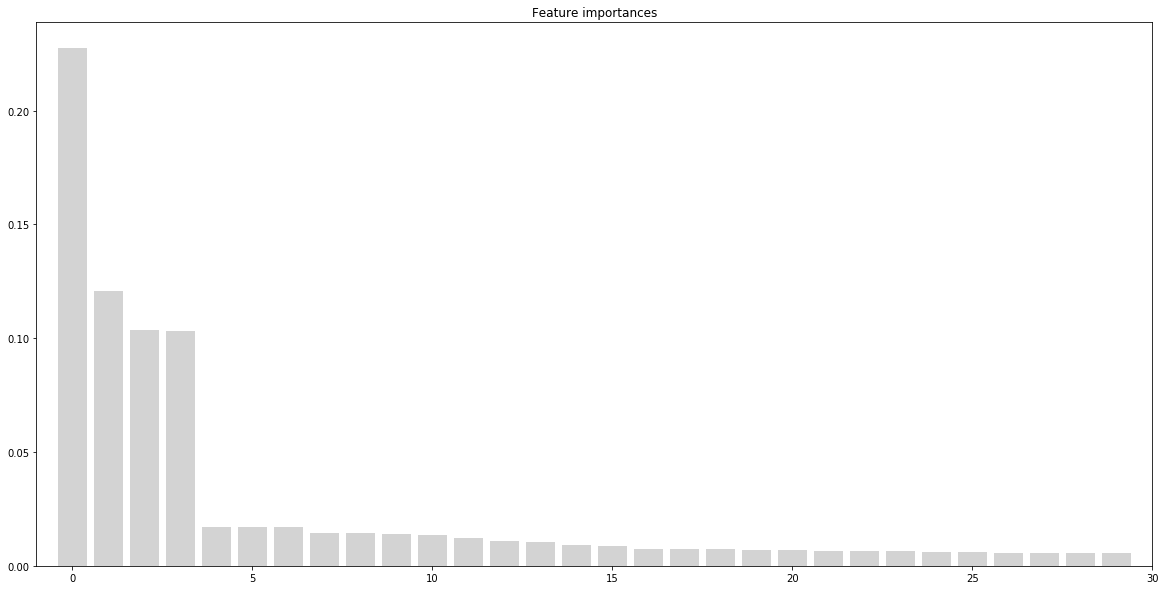

In [15]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(30), importances[indices[0:30]],
       color="lightgrey", align="center")
plt.xlim([-1, 30])
plt.show()

In [16]:
features = X.columns.values.tolist()
keep = []
for i in range(12):
    keep.append(features[indices[i]])
print(keep)

['TaxiOut', 'TaxiIn', 'DepHour', 'CRSElapsedTime', 'MonthPart_3', 'MonthPart_2', 'MonthPart_1', 'DayOfWeek_1', 'DayOfWeek_4', 'DayOfWeek_3', 'DayOfWeek_7', 'DayOfWeek_2']


In [17]:
features = [i for i in features if i not in keep]
check_features = X.drop(columns=features)
check_features.corr()

,CRSElapsedTime,TaxiIn,TaxiOut,DepHour,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_7,MonthPart_1,MonthPart_2,MonthPart_3
CRSElapsedTime,1.000000,0.045455,0.104266,-0.004242,-0.005444,-0.004874,-0.007552,-0.005466,0.005220,0.000380,-0.001561,0.001171
TaxiIn,0.045455,1.000000,0.021396,-0.068089,-0.003124,-0.006413,-0.004763,-0.003500,0.010142,-0.004991,-0.000447,0.005384
TaxiOut,0.104266,0.021396,1.000000,0.029796,-0.005941,0.009594,0.008412,0.019311,-0.008401,0.005314,-0.005887,0.000576
DepHour,-0.004242,-0.068089,0.029796,1.000000,0.000510,-0.000594,0.001332,0.000201,0.016457,-0.000448,0.001981,-0.001520
DayOfWeek_1,-0.005444,-0.003124,-0.005941,0.000510,1.000000,-0.170804,-0.171446,-0.171434,-0.168706,0.003714,-0.011090,0.007316
DayOfWeek_2,-0.004874,-0.006413,0.009594,-0.000594,-0.170804,1.000000,-0.169460,-0.169448,-0.166752,0.005536,0.003388,-0.008838
DayOfWeek_3,-0.007552,-0.004763,0.008412,0.001332,-0.171446,-0.169460,1.000000,-0.170084,-0.167378,-0.005419,-0.003686,0.009017
DayOfWeek_4,-0.005466,-0.003500,0.019311,0.000201,-0.171434,-0.169448,-0.170084,1.000000,-0.167366,0.001325,0.007268,-0.008516
DayOfWeek_7,0.005220,0.010142,-0.008401,0.016457,-0.168706,-0.166752,-0.167378,-0.167366,1.000000,-0.000213,0.000072,0.000139
MonthPart_1,0.000380,-0.004991,0.005314,-0.000448,0.003714,0.005536,-0.005419,0.001325,-0.000213,1.000000,-0.490324,-0.503700


I remove MonthPart_1 as this is a linear combination of MonthPart_2 and MonthPart_3

In [18]:
X = check_features.drop(columns=['MonthPart_1'])
keep.remove('MonthPart_1')

The transformations of the selected variables

In [19]:
def TaxiIn_trsf(X):
    if X['TaxiIn'] < 60:
        return X['TaxiIn']
    else:
        return 60

def TaxiOut_trsf(X):
    if X['TaxiOut'] < 70:
        return X['TaxiOut']
    else:
        return 70

def DepHour_trsf(X):
    return (X['DepHour'])**2

X['TaxiIn'] = X.apply(TaxiIn_trsf, axis=1)
X['TaxiOut'] = X.apply(TaxiOut_trsf, axis=1)
X['DepHour_sq'] = X.apply(DepHour_trsf, axis=1)

Building model

In [20]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              IsDelayed   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                 1.356e+04
Date:                Tue, 15 May 2018   Prob (F-statistic):               0.00
Time:                        02:18:47   Log-Likelihood:            -5.2009e+05
No. Observations:              915069   AIC:                         1.040e+06
Df Residuals:                  915056   BIC:                         1.040e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4223      0.004   -105.